(dask-read-write)=
# Reading and Writing Data

Dask DataFrame supports nearly all data reading and writing operations available in pandas. This includes reading and writing text files, Parquet, HDF, JSON, and other formats from local, NFS, HDFS, or S3 storage. {numref}`dask-read-write-operations` illustrates some common reading and writing operations.

```{table} some reading and writing operations in Dask DataFrame
:name: dask-read-write-operations
|   	| CSV          	| Parquet          	| HDF          	|
|---	|--------------	|------------------	|--------------	|
| Read  	| [`read_csv()`](https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html) 	| [`read_parquet()`](https://docs.dask.org/en/stable/generated/dask.dataframe.read_parquet.html) 	| [`read_hdf()`](https://docs.dask.org/en/stable/generated/dask.dataframe.read_hdf.html) 	|
| Write  	| [`to_csv()`](https://docs.dask.org/en/stable/generated/dask.dataframe.to_csv.html)   	| [`to_parquet()`](https://docs.dask.org/en/stable/generated/dask.dataframe.to_parquet.html)   	| [`to_hdf()`](https://docs.dask.org/en/stable/generated/dask.dataframe.to_hdf.html)   	|
```

## File Systems

:::{tip}
When reading and writing data with Dask clusters, it is recommended to store the data in a shared file system such as NFS, HDFS, or S3, ensuring that all Dask workers can access the data.
:::

File system prefixes (i.e., Schemes) are commonly used in the industry to identify different file systems for reading and writing files. {numref}`uri-schemes` provides examples of several schemes. A dataset address should be a Uniform Resource Identifier (URI) consisting of a scheme and a specific address. The URI template is `scheme://path/to/data`. For example, `file:///tmp/tripdata.parquet` or `s3://tmp/tripdata.parquet`.

```{table} URI Scheme
:name: uri-schemes
|        	|   Local   	|   S3  	|  HDFS 	|
|:------:	|:--------:	|:-----:	|:--------:	|
| Scheme 	| file:// 	| s3:// 	| hdfs:// 	|
```

If no scheme is specified in the dataset address, it is assumed to be a locally accessible file system, i.e., a file system that the computing node can directly read, write, and access. For example, a Network File System (NFS) is a distributed file system mounted to the `/mnt/nfs` directory on multiple computing nodes. When using Dask to read and write to this directory, you can directly use `/mnt/nfs`.

Later sections of this book, such as Ray Data, follow the same URI and scheme standards.

Shared file systems like HDFS and S3 are often shared by multiple users in an enterprise or organization. Therefore, there is usually user authentication to ensure data isolation between users and prevent them from modifying or deleting each other's data. Different file systems have their own methods of user authentication. For instance, S3 users need to provide tokens, and these tokens can be passed into the `storage_options` parameter of methods like `read_*()` and `to_*()` (including `read_csv()`, `read_parquet()`, `to_parquet()`, etc.). If you are unfamiliar with user authentication, consult with colleagues responsible for operations and management in your organization.

## Data Partitioning and Parallel Reading

Let's use the example of reading Comma-Separated Values (CSV) files to illustrate the differences between Dask DataFrame and pandas.

In [1]:
import os
import glob
import urllib
import shutil
import tarfile

folder_path = os.path.join(os.getcwd(), "../data/")
download_url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
tar_file_path = os.path.join(folder_path, "nycflights.tar.gz")
if not os.path.exists(os.path.join(folder_path, "nycflights")):
    urllib.request.urlretrieve(download_url, tar_file_path)
    with tarfile.open(tar_file_path, mode="r:gz") as flights:
            flights.extractall(folder_path)
        
file_path = os.path.join(folder_path, "nycflights", "*.csv")
print(file_path)

/Users/luweizheng/Projects/godaai/distributed-python-en/ch-dask-dataframe/../data/nycflights/*.csv


In [2]:
import dask.dataframe as dd
import pandas as pd
from dask.distributed import LocalCluster, Client

cluster = LocalCluster()
client = Client(cluster)

Both pandas and Dask DataFrame provide the `read_csv()` method for reading CSV files. Dask's [`read_csv()`](https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html) method has parameters almost identical to pandas, which you can refer to in the pandas' [`read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) documentation. In this example, the original data has many columns, and the first three columns are `Year`, `Month`, and `DayofMonth`. The `parse_dates` parameter of the `read_csv()` method is used to parse these three columns into the `datetime64` type and generate a new column `Date`.

In [3]:
ddf = dd.read_csv(file_path, parse_dates={'Date': [0, 1, 2]})

Here, the `file_path` is in the form of `*.csv`, matching all files ending with `csv`. In contrast, pandas' `read_csv()` can only read a single file and does not support wildcards like `*.csv`. If you want to read all files ending with csv in a folder using pandas, you should:

In [4]:
file_list = glob.glob(file_path)
data = []

for p in file_list:
    df = pd.read_csv(p, parse_dates={'Date': [0, 1, 2]})
    data.append(df)

pdf = pd.concat(data)

Check the first three rows of this dataset:

In [5]:
ddf.head(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0


In [6]:
pdf.head(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0


This highlights the difference between Dask DataFrame and pandas. Dask DataFrame accepts wildcards like `*.csv` and can read all files ending with csv in a folder in batches. Dask DataFrame first traverses the `*.csv` directory to understand how many CSV files are present. Then, when constructing the Task Graph, it parallelly initiates multiple pandas processes based on the number of files.

`ddf.visualize()` visualizes the Task Graph, and you can see that for a directory with m CSV files, the Task Graph generates m `read_csv()` subgraphs. These subgraphs are executed by launching m pandas `read_csv()` processes in parallel. In other words, each CSV file corresponds to one Partition. Building the Task Graph based on the number of files is the most straightforward way.

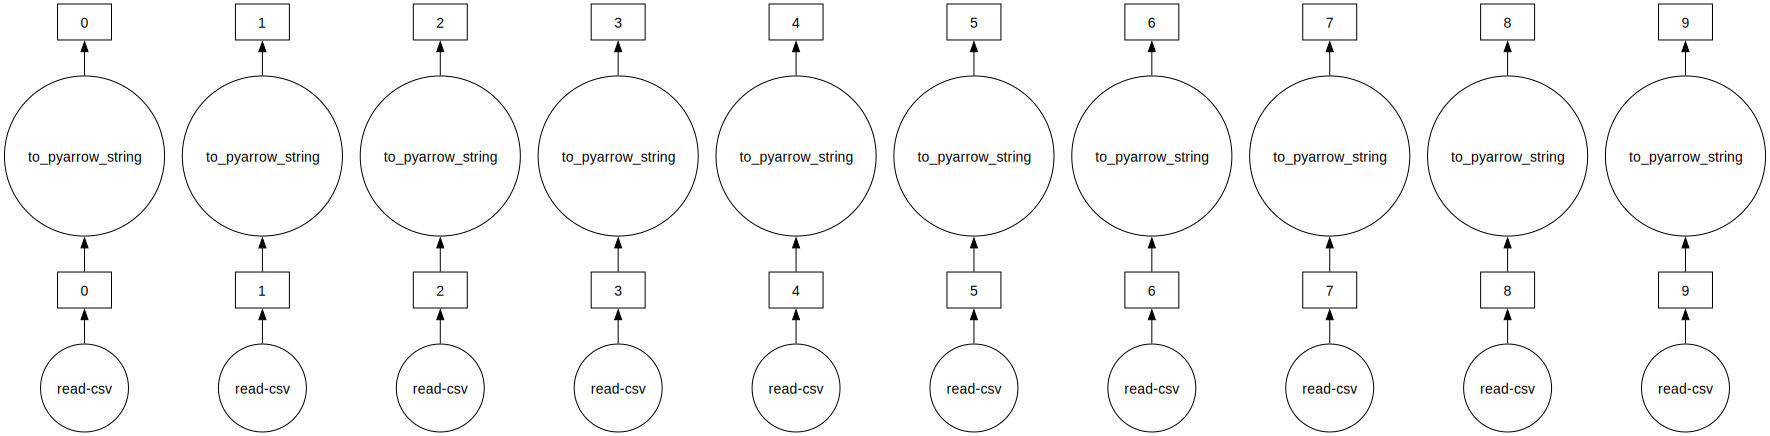

In [7]:
ddf.visualize(filename="../img/ch-dask-dataframe/nyc-flights-graph", format="svg")

In this example, Dask determines the number of partitions based on the number of files. As mentioned in {numref}`dask-task-graph`, splitting data too finely or too coarsely is not ideal for all scenarios. Getting the number of partitions based on the number of files may not be optimal for every situation. If there are many small files, the granularity may be too fine. On the other hand, if it's a single large file, the granularity may be too coarse, potentially leading to out-of-memory (OOM) issues. In these extreme cases, the generated Task Graph may not be optimal.
Dask DataFrame's `read_csv()` provides a parameter, `blocksize`, allowing users to customize the size of each partition. The size of an individual partition will not exceed the specified `blocksize`. If users do not explicitly set `blocksize`, Dask DataFrame will determine the `blocksize` based on the detected computational resources, with a maximum of 64MB.

## Inferring Data Types

Dask DataFrame infers datatypes and records details such as field names and their corresponding data types as schema. The `read_csv()` function in Dask DataFrame introduces a `sample` parameter, indicating the system to read only the initial `sample` bytes of data. The data types are inferred based on this limited dataset. However, this approach poses certain challenges:

Getting the last 3 rows of the `ddf`:

In [8]:
import traceback
try:
    ddf.tail(3)
except Exception:
    traceback.print_exc()

2024-02-10 17:57:34,915 - distributed.worker - WARNING - Compute Failed
Key:       ('to_pyarrow_string-740f4fb47361d8d6d73742e5f29cf9c8', 9)
Function:  execute_task
args:      ((subgraph_callable-d2801090-22cc-4476-8ac9-fa6fe94fa7a9, [(<function read_block_from_file at 0x10e301260>, <OpenFile '/Users/luweizheng/Projects/godaai/distributed-python-en/ch-dask-dataframe/../data/nycflights/1999.csv'>, 0, 25952466, b'\n'), None, True, True]))
kwargs:    {}
Exception: 'ValueError(\'Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.\\n\\n+----------------+---------+----------+\\n| Column         | Found   | Expected |\\n+----------------+---------+----------+\\n| CRSElapsedTime | float64 | int64    |\\n| TailNum        | object  | float64  |\\n+----------------+---------+----------+\\n\\nThe following columns also raised exceptions on conversion:\\n\\n- TailNum\\n  ValueError("could not convert string to float: \\\'N54711\\\'")\\n\\nUsually this is due to dask\\\'s dtype inference faili

`ddf.tail(3)` throws an exception. Why did it raise an exception? Because Dask DataFrame did not read all the data but only the first `sample`-sized portion. In this `sample`-size data, the `CRSElapsedTime` column is empty. Dask DataFrame guessed this field to be of type `float64`, but in later rows, `CRSElapsedTime` is `int64`. In other words, the inferred data type by Dask DataFrame does not match the actual data type encountered.

To address this issue, it's recommended to explicitly specify the data types at the beginning when reading the data:

In [9]:
ddf = dd.read_csv(file_path,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
ddf.tail(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


Now let's add the `blocksize` parameter with values of `50,000` and `5,000,000`. We can compare the speed under different partitions and observe various information provided on the Dask Dashboard. When `blocksize` is set to `50,000`, the Task Graph has a finer granularity, resulting in a larger and more complex Task Graph, making the overall processing time longer.

In [10]:
%%time
ddf = dd.read_csv(file_path, 
                parse_dates={"Date": [0, 1, 2]},
                dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
                blocksize=50_000)

origin_cnt = ddf[~ddf.Cancelled].groupby("Origin").Origin.count().compute()
print(origin_cnt)

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64
CPU times: user 3.04 s, sys: 1.04 s, total: 4.08 s
Wall time: 9.69 s


In [11]:
%%time
ddf = dd.read_csv(file_path, 
                parse_dates={"Date": [0, 1, 2]},
                dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
                blocksize=5_000_000)

origin_cnt = ddf[~ddf.Cancelled].groupby("Origin").Origin.count().compute()
print(origin_cnt)

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64
CPU times: user 82.6 ms, sys: 21.8 ms, total: 104 ms
Wall time: 833 ms


## Parquet

In the realm of big data engineering, [Apache Parquet](https://parquet.apache.org/) is a widely adopted file format. Compared to pure text file types like CSV, Parquet offers the following advantages:

* Columnar storage
* Embedded schema
* Data compression

Columnar storage organizes data by columns instead of rows. Specifically, unlike CSV, which stores data by rows, Parquet stores data via columns. Data analysts are usually interested in specific columns rather than all of them. Parquet allows convenient filtering of unnecessary columns during data reading, resulting in improved performance by reducing the amount of data to be read. Parquet is extensively used in the Apache Spark, Apache Hive, and Apache Flink ecosystems. Parquet inherently includes schema information, embedding metadata such as column names and data types for each column within each Parquet file. This feature eliminates inaccuracies in data types inferring of Dask DataFrame. Data in Parquet is compressed, making it more space-efficient compared to CSV.

For instance, it is advisable to read only the necessary columns rather than all of them:

```python
dd.read_parquet(
    "s3://path/to/parquet/",
    columns=["a", "b", "c"]
)
```

Additionally, Parquet introduces the concept of Row Groups, as illustrated in {numref}`parquet-row-group`. Data in a Parquet file is grouped into Row Groups, defining the number of rows within each group. In the example, there are three Row Groups, each containing two rows of data. Each Row Group stores metadata such as maximum and minimum values of their columns. When querying certain columns, metadata helps determine whether to read a specific Row Group, minimizing unnecessary data retrieval.
For example, if a column represents a time series, and a query involves "sales from 9:00 to 12:00 every day," the metadata within the Row Group records the maximum and minimum values of the time column. By utilizing this metadata, it becomes possible to determine whether it is necessary to read the specific Row Group.

```{figure} ../img/ch-dask-dataframe/parquet-row-group.svg
---
width: 600px
name: parquet-row-group
---
Parquet Columnar Storage with Row Groups
```

With Row Groups, a Parquet file may contain multiple groups. However, many Parquet files have only one Row Group.

Typically, enterprise data files are split into multiple Parquet files and organized in a specific manner, such as by time:

```
/path/folder/
.../year/month/day.parquet
```

When Dask DataFrame reads a Parquet dataset, it considers both file numbers and Row Groups for partitioning. If there are m files, the potential partitioning options are:

* Each Parquet file corresponds to one Dask partition, resulting in m partitions.
* Each Row Group corresponds to one Dask partition. If a Parquet file has n Row Groups, there are m * n partitions.

It is crucial to ensure that the partition's memory usage does not exceed the Worker's physical memory. Dask DataFrame's `read_parquet()` provides users with more options through the `split_row_groups` parameter. Setting it to `split_row_groups=True` enforces one partition per Row Group, while setting it to `False` results in one partition per complete file. The default is `split_row_groups="infer"`, where Dask DataFrame infers whether each complete file or each Row Group corresponds to a partition, by leveraging the file size of the first file.

In [12]:
client.shutdown()